## Logistic Regression

Logistic regression is the process of estimating the **relationship** between **probability of a discreet event** and the independent variables or the regressors.

**Non-linear** decision boundary can be captured by linear logistic model by adding nonlinear features. This is because the model is linear with respect to the parameters. 

**Non-linear (Polynomial)** decision boundary can be captured by linear logistic model by adding nonlinear features. This is because the model is linear with respect to the parameters. 

**Regularization** is a method of controlling model complexity without removing features.

**Multi-Class Logistic Regression** requires Multiple Binary Logistic Regression Analysis to differentiate classes from each other.

----
### Logistic Model (Linear decision boundary)

$$p_i=logistic\left(\sum_jx_{ij}\theta_j\right)$$
Where,
$$ logistic(z)=\frac{1}{1+e^{-z}} $$

|Symbol | Description |
| :---: | :--- |
| $p_i$ | Probability of an event occuring |
| $x_{ij}$ | Design matrix containing regressors of the training data |
| $\theta_j$ | Coefficients of the inner linear model |


In [1]:
clc
close all
clear all
format long
ver Octave

----------------------------------------------------------------------
GNU Octave Version: 7.1.0 (hg id: 04120d65778a)
GNU Octave License: GNU General Public License
Operating System: MINGW32_NT-6.2 Windows 6.2  x86_64
----------------------------------------------------------------------


### Hypothesis function (Binary Logistic Regression)

$$ f_\theta([X]_i)=logistic\left(\sum_jx_{ij}\theta_j\right)=\frac{1}{1+e^{-\left(\sum_jx_{ij}\theta_j\right)}} $$

In [2]:
function f=hypothesisFunction(X,theta)
    f=1./(1+exp(-X*theta));
endfunction

### Prediction function (Binary Logistic Regression)
Taking 0.5 as the threshold probability.

$$ g_\theta([X])=\begin{cases}
 & 1, \text{ if } logistic\left(\sum_jx_{ij}\theta_j\right) \geq 0.5\\
 & 0, \text{ if } logistic\left(\sum_jx_{ij}\theta_j\right) <  0.5
\end{cases}$$

In [3]:
function y=predictionFunction(X,theta,threshold=0.5)
    y=(hypothesisFunction(X,theta)>=threshold);
endfunction

### Prediction function (Multiclass Logistic Regression - Maximum probability)

Select class with maximum predicted probability.

In [4]:
function y=predictionFunctionMulti(X,theta)
    [~,y]=max(hypothesisFunction(X,theta),[],2);
endfunction

### Cost Function and its gradient (Regularized)

$$\begin{aligned}
J([X],y,\theta) & = \frac{1}{m}\sum_{i=1}^m{cost(f_\theta([x]_i),y_i)}+\frac{\lambda}{2m}\sum_{i=2}^m{\theta_i^2} \\
& = -\frac{1}{m}\sum_{i=1}^m{\left[y_ilog(f_\theta([x]_i))+(1-y_i)log(1-f_\theta([x]_i)) \right]} +\frac{\lambda}{2m}\sum_{i=2}^m{\theta_i^2} \\
\nabla J([X],y,\theta)_{j=1} & = \frac{1}{m}\sum_{i=1}^m{(f_\theta([x]_i)-y_i)x_{ij}}  \\
\nabla J([X],y,\theta)_{j=2..n} & = \frac{1}{m}\sum_{i=1}^m{(f_\theta([x]_i)-y_i)x_{ij}} + \frac{\lambda}{m}\theta_j
\end{aligned}
$$
Where,
$$ cost(f_\theta([x]_i),y_i) = \begin{cases}
 & -log(f_\theta([x]_i)), &\text{ if } y_i = 1\\
 & -log(1-f_\theta([x]_i)), &\text{ if } y_i = 0
\end{cases}$$

In [5]:
function [J,gradJ]=costFunctionWithGrad(X,y,theta,lambda=0.1)
    h=hypothesisFunction(X,theta);
    m=length(y);
    J = 1/m*sum(-y.*log(h)-(1-y).*log(1-h))+lambda/2/m*sum(theta(2:end).^2);
    gradJ = 1/m*sum((h-y).*X)'+lambda/m*(theta-[theta(1);zeros(length(theta)-1,1)]);
endfunction

### Model parameter estimation
Minimizing cost by utilizing gradient information

In [6]:
function [f,theta,cost]=modelFit(X,y,initial_theta,lambda=0.1,max_iterations=400)
    options = optimset('GradObj', 'on', 'MaxIter', max_iterations, 'AutoScaling','on');
    [theta, cost] = fminunc(@(t)(costFunctionWithGrad(X, y, t,lambda)), initial_theta, options);
    f=@(X) predictionFunction(X,theta);
endfunction

### Confusion Matrix (Binary Classification)
$$ \text{True Positive (TP) = Num. of True predictions where target is True} $$
$$ \text{True Negative (TN) = Num. of False predictions where target is False} $$
$$ \text{False Positive (FP) = Num. of True predictions where target is False} $$
$$ \text{False Negative (FN) = Num. of False predictions where target is True} $$

|  |(+) Prediction | (-) Prediction |
|:---:|:---:|:---:|
|(+) Actual | TP | FN |
|(-) Actual | FP | TN |



In [7]:
function C=ConfusionMatrix(p,t)
    TruePositive=sum(p==t & t==1);
    TrueNeagtive=sum(p==t & t==0);
    FalsePositive=sum(p~=t & t==0);
    FalseNegative=sum(p~=t & t==1);
    C=[TruePositive  , FalseNegative; 
       FalsePositive , TrueNeagtive];
endfunction

### Multi-class Confusion Matrix

In [8]:
function [C,CID]=MulticlassConfusionMatrix(p,t)
    CID=[];
    CID=unique([unique(t)(:);unique(p)(:)]);
    if isnumeric(CID)
        CID=num2cell(CID);
    endif
    nc=length(CID);
    C=zeros(nc);
    for i=1:nc
        for j=1:nc
            C(i,j)=sum(t==CID{i} & p==CID{j});
        end
    end
endfunction

### MNIST Database Reader
The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

In [9]:
function [imageData,imageSize]=read_MNIST_Images(fileLoc)
    if endsWith(fileLoc,".idx3-ubyte")==1
        [~,fn,fe]=fileparts(fileLoc);
        printf("Reading: %s\n",[fn,fe]);
        inFile=fopen(fileLoc,"r");
        header=fread(inFile,4,"uint32",0,"ieee-be");
        [data,count]=fread(inFile,header(2)*header(3)*header(4),...
                            "uint8",0,"ieee-be");
        fclose(inFile);
        if count~=header(2)*header(3)*header(4)
            disp("Error reading data")
        endif
        imageData=reshape(data,header(3)*header(4),[])';
        imageSize=[header(3) header(4)];
    else
        disp("Can only read *.idx3-ubyte files");
    endif
endfunction

function targetLabelsData=read_MNIST_Labels(fileLoc)
    if endsWith(fileLoc,".idx1-ubyte")==1
        [~,fn,fe]=fileparts(fileLoc);
        printf("Reading: %s\n",[fn,fe]);
        inFile=fopen(fileLoc,"r");
        header=fread(inFile,2,"uint32",0,"ieee-be");
        [data,count]=fread(inFile,header(2),...
                            "uint8",0,"ieee-be");
        fclose(inFile);
        if count~=header(2)
            disp("Error reading data")
        endif
        targetLabelsData=data;
    else
        disp("Can only read *.idx1-ubyte files");
    endif
endfunction

### Data Visualization

In [10]:
function showImagesLabels(indices,imageData,labelsData,imageSize)
    n=numel(indices);
    nc=ceil(sqrt(n));
    nr=ceil(n/nc);

    img=ones(imageSize.*[nr,nc])*255;
    for k=1:n
        c=mod((k-1),nc)*imageSize(2)+1;
        r=floor((k-1)/nc)*imageSize(1)+1;
        img(r:r+imageSize(1)-1,c:c+imageSize(2)-1)=255-reshape(imageData(indices(k),:),imageSize')';
    endfor
    colormap("gray");
    imagesc(img);
    xticks([])
    yticks([])
    title("Image preview");
    disp("Target Labels:");
    disp(reshape(labelsData(indices),[nr,nc]')');
endfunction

### Preety print table

In [11]:
function o=stringCenter(s,w)
    if iscell(s)~=1
        fs=ceil((w-length(s))/2);
        o=[repelem(" ",fs) s repelem(" ",w-fs-length(s))];
    else
        o=cell(length(s),1);
        for k=1:length(s)
            fs=ceil((w-length(s{k}))/2);
            o{k}=[repelem(" ",fs) s{k} repelem(" ",w-fs-length(s{k}))];
        endfor
    endif
endfunction
function prettyPrintTable(T,rn,cn,rh,ch,cw=8,f="%i")
    c=size(T,2);
    rhl=floor(size(T,1)/2+0.5);
    cnm=max(cellfun(@numel,cn));
    rnm=max(cellfun(@numel,rn));
    cw=max([cw cnm rnm max(arrayfun(@(x) numel(num2str(x,f)),T(:),"UniformOutput", true))]);
    tw=c*cw+c+1;
    printf([repelem(' ',length(rh)+1+1+cw) '+' repelem('-',tw-2) '+\n']);
    printf([repelem(' ',length(rh)+1+1+cw) '|' stringCenter(ch,tw-2) '|\n'])
    printf([repelem(' ',length(rh)+1+1+cw) '+' repmat([repelem('-',cw) '+'],1,c) '\n'])
    printf([repelem(' ',length(rh)+1+1+cw) '|' sprintf(sprintf("%%%is|",cw),stringCenter(cn,cw){:}) '\n'])
    printf(['+' repelem('-',length(rh)) '+' repelem('-',cw) '+' repmat([repelem('-',cw) '+'],1,c) '\n'])
    for k=1:length(rn)
        if(k~=rhl)
            p=['|' repelem(' ',length(rh)) '|' stringCenter(rn{k},cw) '|'];
        else
            p=['|' rh '|' stringCenter(rn{k},cw) '|'];
        endif
        for j=1:length(cn)           
            p=strcat(p,sprintf(sprintf("%%%is|",cw),stringCenter(sprintf(f,T(k,j)),cw)));
        endfor
        printf([p '\n'])
    endfor
        printf(['+' repelem('-',length(rh)) '+' repelem('-',cw) '+' repmat([repelem('-',cw) '+'],1,c) '\n'])
endfunction

### Main Program

Reads MNIST database and performs multi-class logistic regression analysis.

Reading MNIST Training Database
Reading: train-images.idx3-ubyte
Reading: train-labels.idx1-ubyte
First 100 Entries:
Target Labels:
   5   0   4   1   9   2   1   3   1   4
   3   5   3   6   1   7   2   8   6   9
   4   0   9   1   1   2   4   3   2   7
   3   8   6   9   0   5   6   0   7   6
   1   8   7   9   3   9   8   5   9   3
   3   0   7   4   9   8   0   9   4   1
   4   4   6   0   4   5   6   1   0   0
   1   7   1   6   3   0   2   1   1   7
   9   0   2   6   7   8   3   9   0   4
   6   7   4   6   8   0   7   8   3   1


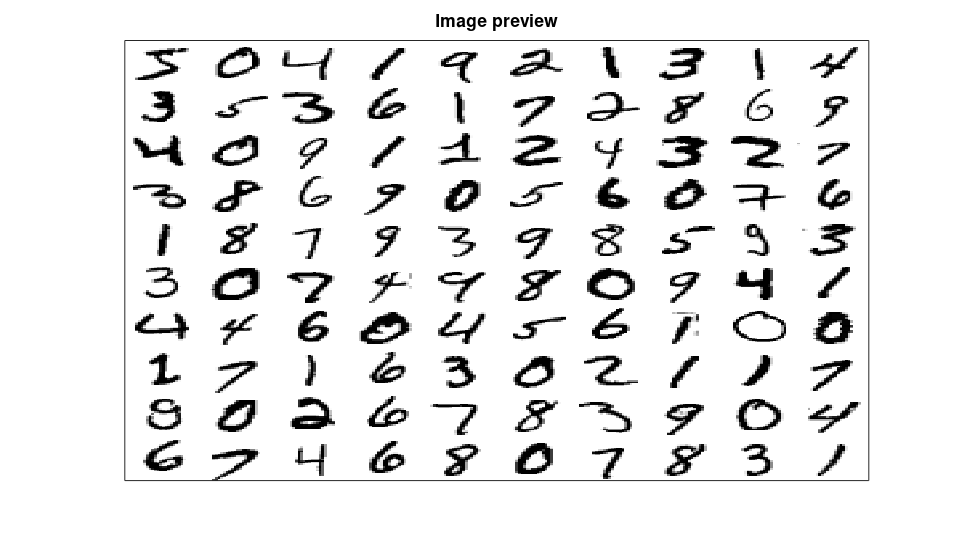

In [12]:
format short
disp("Reading MNIST Training Database");
[fname,fpath]=uigetfile("*.idx3-ubyte","Training Image Database");
fileLocImages=fullfile(fpath,fname);
[imageData imageSize]=read_MNIST_Images(fileLocImages);

[fname,fpath]=uigetfile("*.idx1-ubyte","Training Label Database");
fileLocLabels=fullfile(fpath,fname);
labelsData=read_MNIST_Labels(fileLocLabels);

disp("First 100 Entries:");
showImagesLabels(1:100,imageData,labelsData,imageSize);

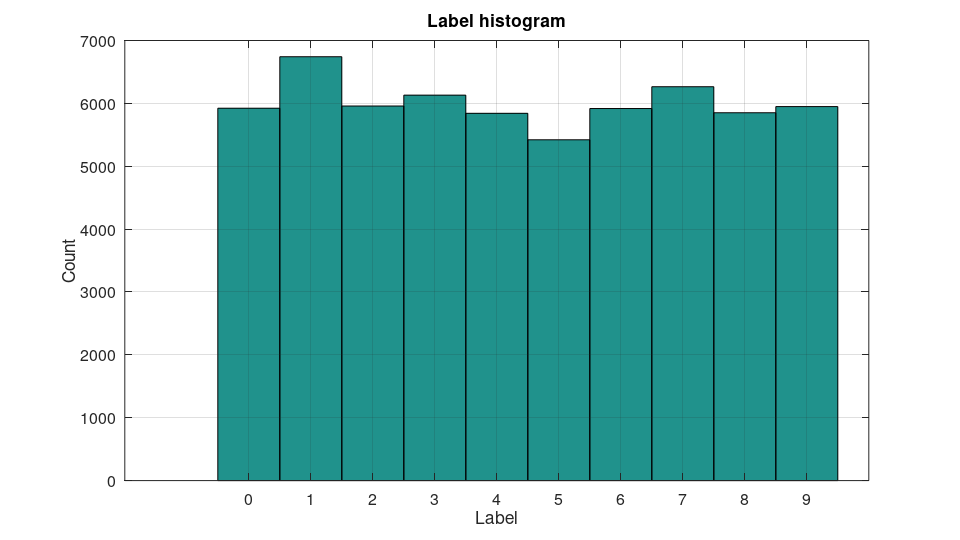

In [13]:
hist(labelsData,(0:9))
xticks(0:9)
grid("on")
title("Label histogram");
xlabel("Label");
ylabel("Count");

### Training Phase

In [14]:
%%time
X=[ones(length(labelsData),1) imageData/255];
y=labelsData;
T=zeros(size(X,2),10);
count=0;
disp("----------------------------")
for k=1:10
    initial_theta=zeros(size(X,2),1);
    [fitM,theta,cost]=modelFit(X,y==(k-1),initial_theta,lambda=1,max_iterations=1000);
    T(:,k)=theta;
    C=ConfusionMatrix(fitM(X),y==(k-1));
    printf('Confusion Matrix for digit: %d\n',k-1);
    prettyPrintTable(C,{'+','-'},{'+','-'},"Actual","Predicted",8,"%i")
    printf("Cost = %g\n",cost)
    count=count+C(1);
    disp("----------------------------")
endfor
printf("Training Accuracy = %g%%\n",count/length(labelsData)*100)

----------------------------
Confusion Matrix for digit: 0
                +-----------------+
                |    Predicted    |
                +--------+--------+
                |    +   |    -   |
+------+--------+--------+--------+
|Actual|    +   |  5698  |   225  |
|      |    -   |   149  |  53928 |
+------+--------+--------+--------+
Cost = 0.0225654
----------------------------
Confusion Matrix for digit: 1
                +-----------------+
                |    Predicted    |
                +--------+--------+
                |    +   |    -   |
+------+--------+--------+--------+
|Actual|    +   |  6558  |   184  |
|      |    -   |   226  |  53032 |
+------+--------+--------+--------+
Cost = 0.0246339
----------------------------
Confusion Matrix for digit: 2
                +-----------------+
                |    Predicted    |
                +--------+--------+
                |    +   |    -   |
+------+--------+--------+--------+
|Actual|    +   |  5172  |   786 

In [15]:
disp("Reading MNIST Testing Database");
[fname,fpath]=uigetfile("*.idx3-ubyte","Testing Image Database");
fileLocImages=fullfile(fpath,fname);
[imageDataTest imageSizeTest]=read_MNIST_Images(fileLocImages);

[fname,fpath]=uigetfile("*.idx1-ubyte","Testing Label Database");
fileLocLabels=fullfile(fpath,fname);
labelsDataTest=read_MNIST_Labels(fileLocLabels);

Reading MNIST Testing Database
Reading: t10k-images.idx3-ubyte
Reading: t10k-labels.idx1-ubyte


### Testing Phase

In [16]:
X=[ones(length(labelsDataTest),1) imageDataTest/255];
y=labelsDataTest;
p=hypothesisFunction(X,T);
disp("----------------------------")
count=0;
for k=1:10
    C=ConfusionMatrix(p(:,k)>=0.5,y==(k-1));
    printf('Confusion Matrix for digit: %d\n',k-1);
    prettyPrintTable(C,{'+','-'},{'+','-'},"Actual","Predicted",8,"%i")
    count=count+C(1);
    disp("----------------------------")
endfor
printf("Testing Accuracy = %g%%\n",count/length(labelsDataTest)*100)

----------------------------
Confusion Matrix for digit: 0
                +-----------------+
                |    Predicted    |
                +--------+--------+
                |    +   |    -   |
+------+--------+--------+--------+
|Actual|    +   |   944  |   36   |
|      |    -   |   44   |  8976  |
+------+--------+--------+--------+
----------------------------
Confusion Matrix for digit: 1
                +-----------------+
                |    Predicted    |
                +--------+--------+
                |    +   |    -   |
+------+--------+--------+--------+
|Actual|    +   |  1107  |   28   |
|      |    -   |   35   |  8830  |
+------+--------+--------+--------+
----------------------------
Confusion Matrix for digit: 2
                +-----------------+
                |    Predicted    |
                +--------+--------+
                |    +   |    -   |
+------+--------+--------+--------+
|Actual|    +   |   883  |   149  |
|      |    -   |   40   |  892

### Prediction on first 100 Test Images

Predicted labels for first 100 Test Images:
   7   2   1   0   4   1   4   9   6   9
   0   6   9   0   1   5   9   7   3   4
   9   6   6   5   4   0   7   4   0   1
   3   1   3   4   7   2   7   1   3   1
   1   7   4   2   3   5   1   2   4   4
   6   3   5   5   6   0   4   1   9   5
   7   8   9   2   7   4   6   4   3   0
   7   0   2   9   1   7   3   2   9   7
   7   6   2   7   8   4   7   3   6   1
   3   6   9   3   1   4   1   7   6   9
Target Labels:
   7   2   1   0   4   1   4   9   5   9
   0   6   9   0   1   5   9   7   3   4
   9   6   6   5   4   0   7   4   0   1
   3   1   3   4   7   2   7   1   2   1
   1   7   4   2   3   5   1   2   4   4
   6   3   5   5   6   0   4   1   9   5
   7   8   9   3   7   4   6   4   3   0
   7   0   2   9   1   7   3   2   9   7
   7   6   2   7   8   4   7   3   6   1
   3   6   9   3   1   4   1   7   6   9


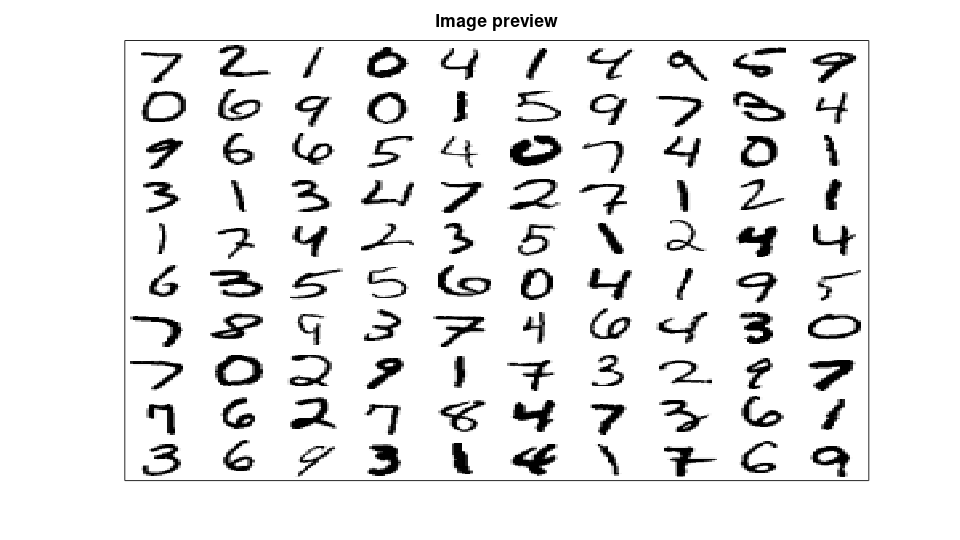

In [17]:
q=predictionFunctionMulti(X,T);
disp("Predicted labels for first 100 Test Images:");
disp(reshape(q(1:100)-1,10,[])');
showImagesLabels(1:100,imageDataTest,labelsDataTest,imageSizeTest);

### Multiclass Confusion Matrix (Maximum probability classification)

In [18]:
[C,CID]=MulticlassConfusionMatrix(q-1,y);
if(isnumeric(CID{1}))
    CID=cellfun(@num2str,CID,"UniformOutput",false);
endif

disp("Multiclass Confusion Matrix (Maximum probability classification):\n")
prettyPrintTable(C,CID,CID,"Actual","Predicted",8,"%4i")

Multiclass Confusion Matrix (Maximum probability classification):

                +-----------------------------------------------------------------------------------------+
                |                                        Predicted                                        |
                +--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
                |    0   |    1   |    2   |    3   |    4   |    5   |    6   |    7   |    8   |    9   |
+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|      |    0   |   961  |     0  |     1  |     3  |     0  |     4  |     5  |     3  |     1  |     2  |
|      |    1   |     0  |  1111  |     3  |     2  |     0  |     1  |     5  |     1  |    12  |     0  |
|      |    2   |     8  |     7  |   920  |    19  |    11  |     4  |    10  |    10  |    39  |     4  |
|      |    3   |     5  |     1  |    18  |   918  |     2  |    21 